In [1]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import time
import nltk
import pandas as pd
import re

In [2]:
docs_path = 'IRWA_data_2023/Rus_Ukr_war_data.json'
with open(docs_path) as fp:
    lines = fp.readlines()

In [3]:
df=pd.read_json(docs_path, lines=True)

In [4]:
df_clean = df[["created_at","id_str","full_text","entities","favorite_count","retweet_count","user"]]

renames = {"created_at":"date", "full_text":"tweet", "favorite_count":"likes","retweet_count":"retweets", "id_str":"tweet_id"}
df_clean=df_clean.rename(columns=renames)

In [5]:
df_hashtags = pd.json_normalize(df_clean["entities"])["hashtags"]

df_hashtags = df_hashtags.apply(lambda x: [item["text"] for item in x])

df_user = pd.json_normalize(df_clean["user"])["id"].rename("user_id")

df_concat = pd.concat([df_clean,df_hashtags,df_user], axis=1).drop(columns=["entities","user"])

df_concat["url"] = "https://twitter.com/" + df_concat["user_id"].astype(str) + "/status/" + df_concat["tweet_id"].astype(str)

df_concat.head(1)

,date,tweet_id,tweet,likes,retweets,hashtags,user_id,url
0,2022-09-30 18:39:17+00:00,1575918221013979136,@MelSimmonsFCDO Wrong. Dictator Putin's Fascis...,0,0,"[RussiainvadesUkraine, UkraineRussiaWar]",1404526426330701825,https://twitter.com/1404526426330701825/status...


In [6]:
df_concat["tags"] = df_concat["tweet"].apply(lambda x: re.findall(r"@(\w+)", x))
df_def = df_concat.copy()

In [7]:
for i in df_concat["tweet"].head(3):
    print(i)
    print("\n")

@MelSimmonsFCDO Wrong. Dictator Putin's Fascist Russia intends to conquer as much Ukrainian Land as possible.
#RussiainvadesUkraine
#UkraineRussiaWar


🇺🇦❤️ The Armed Forces liberated the village of #Drobysheve of the #Lymansk urban territorial community in #Donetsk region.#UkraineRussiaWar
#UkraineWar #Ukraine️ #UkraineWillWin #UkrainianArmy #ukrainecounteroffensive #UkraineWarNews #SlavaUkraïni #StandWithUkraine https://t.co/ifg0RXDMBQ


ALERT 🚨Poland preps anti-radiation tablets over nuclear threat

#NATO #Putin #Russia #RussiaInvadedUkraine #Ukraine #UkraineRussiaWar




In [8]:
def remove_emojis(tweet):
    # Patrón para encontrar emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticonos
                           u"\U0001F300-\U0001F5FF"  # símbolos & pictogramas
                           u"\U0001F680-\U0001F6FF"  # transporte & símbolos del mapa
                           u"\U0001F1E0-\U0001F1FF"  # banderas (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', tweet)


def clean_tweet(line):
    
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    ## START CODE
    line = re.sub(r'[.,;:!?"\'-@]', '', line).replace("#", "").replace("’", "").replace("“", "").replace("\n"," ")
    line =  line.lower() ## Transform in lowercase
    line = remove_emojis(line).strip().replace("  ", " ")
    line = line.split(" ") ## Tokenize the text to get a list of terms
    line =[word for word in line if word not in stop_words]  ##eliminate the stopwords (HINT: use List Comprehension)
    line =[stemmer.stem(word) for word in line] ## perform stemming (HINT: use List Comprehension)
    line = [word for word in line if word != ""]
    ## END CODE
    
    return line

In [9]:
#df_def["clean_tweet"] = [clean_tweet(l) for l in df_def["tweet"]]
df_def["clean_tweet"] = df_def["tweet"].apply(clean_tweet)

In [10]:
docs = pd.read_csv("IRWA_data_2023/Rus_Ukr_war_data_ids.csv", sep="\t", header=None)
docs = docs.rename(columns={0:"doc_id",1:"tweet_id"})
tweets = df_def.join(docs.set_index('tweet_id'), on='tweet_id')

## EXPLORATORY DATA ANALYSIS

In [35]:
import seaborn as sns
from wordcloud import WordCloud
from matplotlib import pyplot as plt
from PIL import Image

In [18]:
exploded_df = tweets.explode("clean_tweet")
word_list = exploded_df["clean_tweet"].tolist()

In [20]:
exploded_df.isnull().sum()

date               0
tweet_id           0
tweet              0
likes              0
retweets           0
hashtags           0
user_id            0
url                0
tags               0
clean_tweet        0
doc_id         32261
dtype: int64

In [45]:
word_count = {}
for word in word_list:
    if word in word_count.keys():
        word_count[word] += 1
    else:
        word_count[word] = 1

word_count = dict(sorted(word_count.items(),key=lambda item: item[1], reverse = True))

### Barplot Top 10 most used words

<AxesSubplot:>

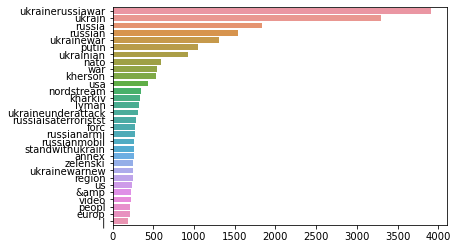

In [47]:
sns.barplot(x=list(word_count.values())[:30], y=list(word_count.keys())[:30])

In [49]:
print(word_list)

['melsimmonsfcdo', 'wrong', 'dictat', 'putin', 'fascist', 'russia', 'intend', 'conquer', 'much', 'ukrainian', 'land', 'possibl', 'russiainvadesukrain', 'ukrainerussiawar', 'arm', 'forc', 'liber', 'villag', 'drobyshev', 'lymansk', 'urban', 'territori', 'commun', 'donetsk', 'regionukrainerussiawar', 'ukrainewar', 'ukrain', 'ukrainewillwin', 'ukrainianarmi', 'ukrainecounteroffens', 'ukrainewarnew', 'slavaukraïni', 'standwithukrain', 'httpstcoifgrxdmbq', 'alert', 'poland', 'prep', 'antiradi', 'tablet', 'nuclear', 'threat', 'nato', 'putin', 'russia', 'russiainvadedukrain', 'ukrain', 'ukrainerussiawar', 'im', 'still', 'wait', 'googl', 'map', 'updat', 'russia', 'new', 'annex', 'territori', 'take', 'bit', 'longer', 'thought', '🤔', 'putin', 'ukrainerussiawar', 'emmanuelmacron', 'probabl', 'your', 'right', 'say', 'anyway', 'game', 'european', 'citizen', 'tire', 'pay', 'endless', 'ukrainerussiawar', 'estonia', 'lithuania', 'latvia', 'fulli', 'support', 'welcom', 'ukrain', 'nato', 'soon', 'possibl

In [21]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


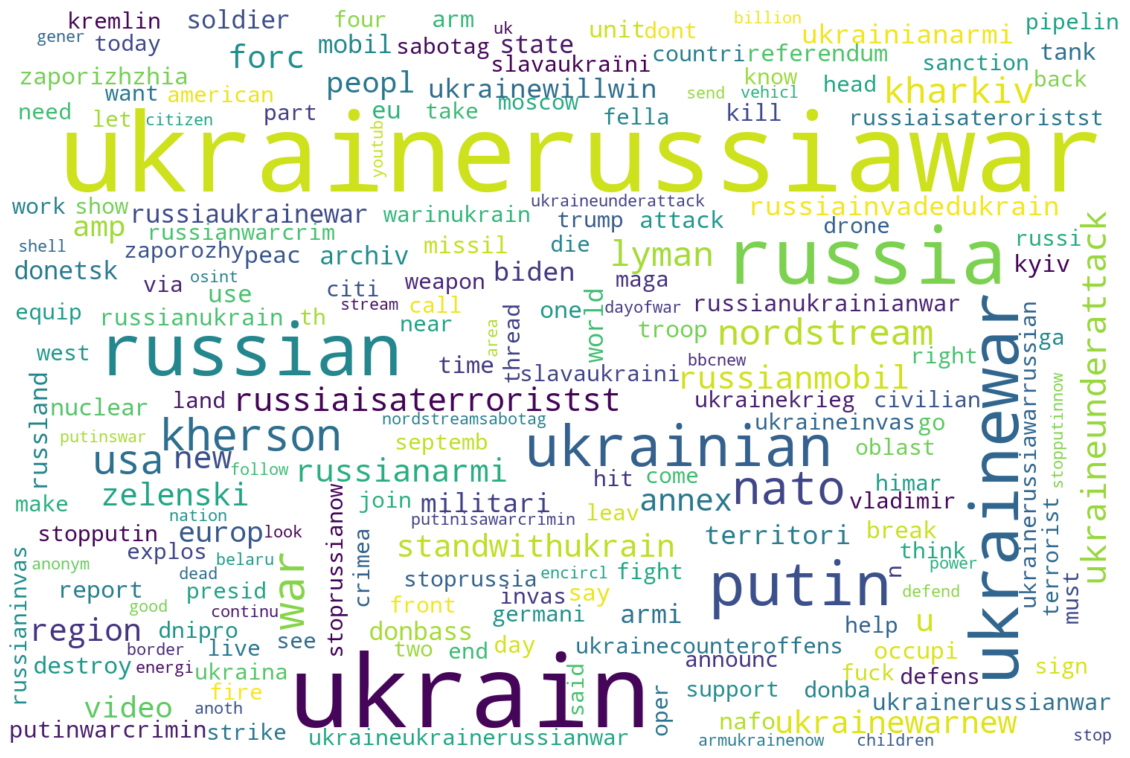

In [52]:
wordcloud = WordCloud(collocations = False,
                      background_color = "white",
                      width = 1500,
                      height = 1000).generate(' '.join(word_list))
plt.figure(figsize = (20, 15))
plt.imshow(wordcloud,
           interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Histogram of the number of likes

<AxesSubplot:xlabel='likes', ylabel='Count'>

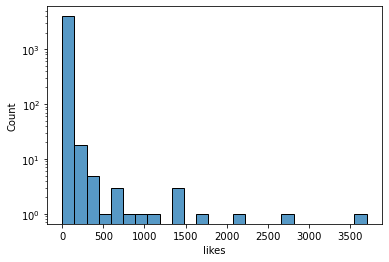

In [64]:
sns.histplot(tweets['likes'], log_scale = (False, True), bins = 25)

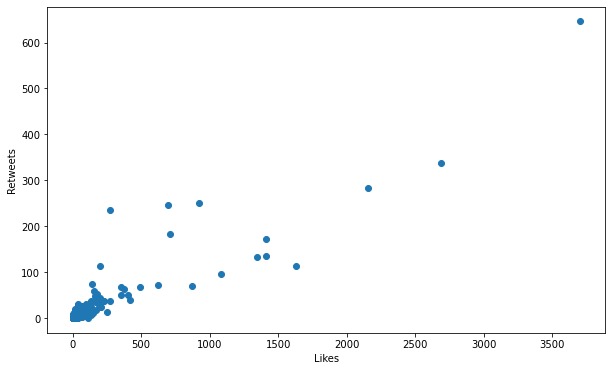

In [65]:
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(tweets['likes'], tweets['retweets'])
ax.set_xlabel('Likes')
ax.set_ylabel('Retweets')
plt.show()